<table style="border: none" align="center">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="4" color="black"><b>  Face recognition attacks  </b></font></font></th>
   </tr> 
</table>

<a id="prereqs"></a>
## 1. Loading prereqs

In [1]:
!pip install -q tensorflow==2.0.0
!pip install adversarial-robustness-toolbox[all]
!pip install h5py==2.10.0
!pip install git+https://github.com/JanderHungrige/tf.keras-vggface
!pip install Pillow

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from art import config
from art.estimators.classification import KerasClassifier

import PIL
import art

if tf.__version__[0] != '2':
    raise ImportError('This notebook requires TensorFlow v2.')

print("\nTensorflow Version: " + tf.__version__)
print("ART Version: " + art.__version__)
print("GPU Available: ", tf.test.is_gpu_available())

     |████████████████████████████████| 86.3 MB 32 kB/s 
     |████████████████████████████████| 3.8 MB 26.1 MB/s 
     |████████████████████████████████| 449 kB 30.3 MB/s 
     |████████████████████████████████| 50 kB 3.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-probability 0.16.0 requires gast>=0.3.2, but you have gast 0.2.2 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 7.5 MB/s 
     |████████████████████████████████| 249 kB 57.1 MB/s 
     |████████████████████████████████| 1.1 MB 43.1 MB/s 
     |████████████████████████████████| 49.1 MB 2.3 MB/s 
     |████████████████████████████████| 551 kB 46.0 MB/s 
     |████████████████████████████████| 76.8 MB 1.2 MB/s 
  Attempting uninstall: graphviz
    Found existing

In [2]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessiing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

<a id="classifier"></a>
## 2. Evaluating the classifier

Load the pre-trained classifier (a ResNet architecture):

In [ ]:
from keras_vggface_TF.vggfaceTF import VGGFace
classifier_model = VGGFace(model='resnet50', include_top=True, input_shape=(224, 224, 3), pooling='avg')
classifier = KerasClassifier(clip_values=(0, 255), model=classifier_model, use_logits=False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


I Am  none
165445632/165439116 [==============================] - 11s 0us/step


In [ ]:
classifier_model.summary()

Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________________

Evaluate the classifier on the original two images:

In [ ]:
from keras_vggface_TF import utils
from io import BytesIO
from PIL import Image
import requests

# Brad Pitt
response = requests.get("http://www.voxy.co.nz/files/imagecache/news_item_image/files/brad-pitt-square_1.jpg")
img_bytes = BytesIO(response.content)
brad_img = Image.open(img_bytes).resize((224,224))
brad = tf.keras.preprocessing.image.img_to_array(brad_img)
# Bob Marley
response = requests.get("https://pbs.twimg.com/media/D_dApiWUwAAmDC1.jpg")
img_bytes = BytesIO(response.content)
bob_img = Image.open(img_bytes).resize((224,224))
bob = tf.keras.preprocessing.image.img_to_array(bob_img)

brad = utils.preprocess_input(brad, version=1).reshape(1,224,224,3)
brad_pred = np.argmax(classifier.predict(brad), axis=1)
bob = utils.preprocess_input(bob, version=1).reshape(1,224,224,3)
bob_pred = np.argmax(classifier.predict(bob), axis=1)

fpath = tf.keras.utils.get_file('rcmalli_vggface_labels_v2.npy',
                             "https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_labels_v2.npy",
                             cache_subdir="./")
LABELS = np.load(fpath)

print("Original test data:")
print("Brad classified: {}".format(LABELS[brad_pred[0]]))
print("Bob classified: {}".format(LABELS[bob_pred[0]]))

For illustration purposes, look at the 2 images

In [ ]:
plt.figure()
plt.imshow(brad_img)
plt.title("Model Prediction: {}\n".format(LABELS[brad_pred[0]]))
plt.show()

plt.figure()
plt.imshow(bob_img)
plt.title("Model Prediction: {}\n".format(LABELS[bob_pred[0]]))
plt.show()

In [ ]:
from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import BasicIterativeMethod
from art.attacks.evasion import ProjectedGradientDescent
from art.attacks.evasion import CarliniL2Method
from art.attacks.evasion import DeepFool

from art.defences.trainer import AdversarialTrainer
import cv2

## 3. Attacks

### BIM

Generate error-generic adversarial samples:

In [ ]:
# TO DO
epsilon = 4
max_iter = 20
epsilon_step = epsilon/max_iter

attack = BasicIterativeMethod(estimator=classifier, eps=epsilon, eps_step=epsilon_step, max_iter=max_iter, targeted=False)

In [ ]:
bob_adv = attack.generate(bob)
brad_adv = attack.generate(brad)

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluate the classifier on the 2 error-generic adversarial samples:

In [ ]:
# TO DO
bob_adv_pred = np.argmax(classifier.predict(bob_adv), axis=1)
brad_adv_pred = np.argmax(classifier.predict(brad_adv), axis=1)

Now plot the adversarial images and their predicted labels.

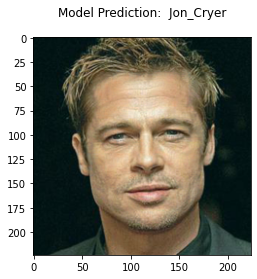

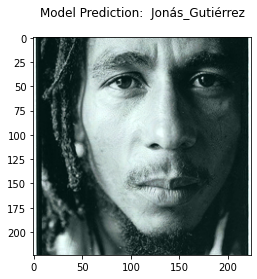

In [ ]:
brad_adv_img = deprocess_img(brad_adv[0])
bob_adv_img = deprocess_img(bob_adv[0])

# TO DO
plt.figure()
plt.imshow(brad_adv_img)
plt.title("Model Prediction: {}\n".format(LABELS[brad_adv_pred[0]]))
plt.show()

plt.figure()
plt.imshow(bob_adv_img)
plt.title("Model Prediction: {}\n".format(LABELS[bob_adv_pred[0]]))
plt.show()

Generate error-specific adversarial samples:

In [ ]:
# TO DO
epsilon = 190
max_iter = 100
epsilon_step = epsilon/max_iter

attack = BasicIterativeMethod(estimator=classifier, eps=epsilon, eps_step=epsilon_step, max_iter=max_iter, targeted=False)

In [ ]:
# TO DO
bob_class_num = 160
targeted_labels = bob_class_num*np.ones(1)
one_hot_targeted_labels = tf.keras.utils.to_categorical(targeted_labels, num_classes = LABELS.size)
brad_to_bob = attack.generate(brad, one_hot_targeted_labels)

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluate the classifier on the 2 error-specific adversarial samples:

In [ ]:
# TO DO
brad2bob_pred = np.argmax(classifier.predict(brad_to_bob), axis=1)

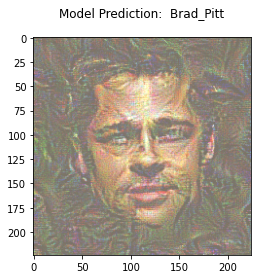

In [ ]:
# TO DO
brad2bob_img = deprocess_img(brad_to_bob)

plt.figure()
plt.imshow(brad2bob_img)
plt.title("Model Prediction: {}\n".format(LABELS[brad2bob_pred[0]]))
plt.show()

### PGD

Generate error-generic adversarial samples:

In [ ]:
# TO DO
epsilon = 5
max_iter = 20
epsilon_step = epsilon/max_iter
num_random_init = 23

attack = ProjectedGradientDescent(estimator=classifier, eps=epsilon, eps_step=epsilon_step, max_iter=max_iter, num_random_init=num_random_init, targeted=False)

In [ ]:
bob_adv = attack.generate(bob)
brad_adv = attack.generate(brad)

PGD - Random Initializations:   0%|          | 0/23 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/23 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluate the classifier on the 2 error-generic adversarial samples:

In [ ]:
# TO DO
bob_adv_pred = np.argmax(classifier.predict(bob_adv), axis=1)
brad_adv_pred = np.argmax(classifier.predict(brad_adv), axis=1)

Now plot the adversarial images and their predicted labels.

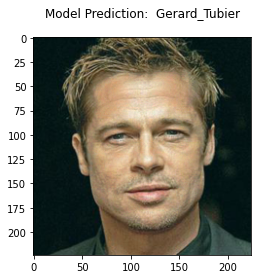

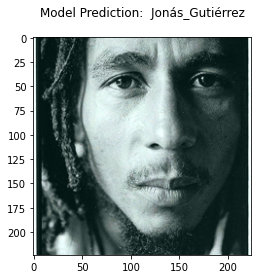

In [ ]:
brad_adv_img = deprocess_img(brad_adv[0])
bob_adv_img = deprocess_img(bob_adv[0])

# TO DO
plt.figure()
plt.imshow(brad_adv_img)
plt.title("Model Prediction: {}\n".format(LABELS[brad_adv_pred[0]]))
plt.show()

plt.figure()
plt.imshow(bob_adv_img)
plt.title("Model Prediction: {}\n".format(LABELS[bob_adv_pred[0]]))
plt.show()

Generate error-specific adversarial samples:

In [ ]:
# TO DO
epsilon = 20
max_iter = 5
epsilon_step = epsilon/max_iter

attack = ProjectedGradientDescent(estimator=classifier, eps=epsilon, eps_step=epsilon_step, max_iter=max_iter, num_random_init=num_random_init, targeted=True)

In [ ]:
# TO DO
bob_class_num = 1050
targeted_labels = bob_class_num*np.ones(1)
one_hot_targeted_labels = tf.keras.utils.to_categorical(targeted_labels, num_classes = LABELS.size)
brad_to_bob = attack.generate(brad, one_hot_targeted_labels)

PGD - Random Initializations:   0%|          | 0/23 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/5 [00:00<?, ?it/s]

Evaluate the classifier on the 2 error-specific adversarial samples:

In [ ]:
# TO DO
brad2bob_pred = np.argmax(classifier.predict(brad_to_bob), axis=1)

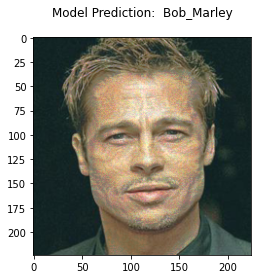

In [ ]:
# TO DO
brad2bob_img = deprocess_img(brad_to_bob)

plt.figure()
plt.imshow(brad2bob_img)
plt.title("Model Prediction: {}\n".format(LABELS[brad2bob_pred[0]]))
plt.show()

### DeepFool

Generate error-generic adversarial samples:

In [ ]:
# TO DO
# Create a ART Keras classifier for the TensorFlow Keras model.
logit_model = tf.keras.Model(classifier_model.input, classifier_model.layers[-2].output)
classifier = KerasClassifier(model=logit_model, clip_values=(0, 255))

epsilon = 23
max_iter = 5
attack = DeepFool(classifier=classifier, epsilon=epsilon, max_iter=max_iter)

In [ ]:
bob_adv = attack.generate(bob)
brad_adv = attack.generate(brad)

Evaluate the classifier on the 2 error-generic adversarial samples:

In [ ]:
# TO DO
bob_adv_pred = np.argmax(classifier.predict(bob_adv), axis=1)
brad_adv_pred = np.argmax(classifier.predict(brad_adv), axis=1)

Now plot the adversarial images and their predicted labels.

In [ ]:
brad_adv_img = deprocess_img(brad_adv[0])
bob_adv_img = deprocess_img(bob_adv[0])

# TO DO
plt.figure()
plt.imshow(brad_adv_img)
plt.title("Model Prediction: {}\n".format(LABELS[brad_adv_pred[0]]))
plt.show()

plt.figure()
plt.imshow(bob_adv_img)
plt.title("Model Prediction: {}\n".format(LABELS[bob_adv_pred[0]]))
plt.show()

### Carlini&Wagner


Generate error-generic adversarial samples:

In [ ]:
# TO DO
# Create a ART Keras classifier for the TensorFlow Keras model.
logit_model = tf.keras.Model(classifier_model.input, classifier_model.layers[-2].output)
classifier = KerasClassifier(model=logit_model, clip_values=(0, 255))

confidence = 0.2
learning_rate = 0.1
binary_search_steps = 5
max_iter = 5
initial_const = 1

attack = CarliniL2Method(classifier=classifier, binary_search_steps=binary_search_steps, confidence=confidence, max_iter=max_iter, learning_rate=learning_rate, initial_const=initial_const, targeted=False)

In [ ]:
bob_adv = attack.generate(bob)
brad_adv = attack.generate(brad)

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluate the classifier on the 2 error-generic adversarial samples:

In [ ]:
# TO DO
bob_adv_pred = np.argmax(classifier.predict(bob_adv), axis=1)
brad_adv_pred = np.argmax(classifier.predict(brad_adv), axis=1)

Now plot the adversarial images and their predicted labels.

In [ ]:
brad_adv_img = deprocess_img(brad_adv[0])
bob_adv_img = deprocess_img(bob_adv[0])

# TO DO
plt.figure()
plt.imshow(brad_adv_img)
plt.title("Model Prediction: {}\n".format(LABELS[brad_adv_pred[0]]))
plt.show()

plt.figure()
plt.imshow(bob_adv_img)
plt.title("Model Prediction: {}\n".format(LABELS[bob_adv_pred[0]]))
plt.show()

Generate error-specific adversarial samples:

In [ ]:
# TO DO

binary_search_steps = 1
confidence = 0.5
max_iter = 50
learning_rate = 0.01
initial_const = 1000

attack = CarliniL2Method(classifier=classifier, binary_search_steps=binary_search_steps, confidence=confidence, max_iter=max_iter, learning_rate=learning_rate, initial_const=initial_const, targeted=True)

In [ ]:
# TO DO
bob_class_num = 1050
targeted_labels = bob_class_num*np.ones(1)
one_hot_targeted_labels = tf.keras.utils.to_categorical(targeted_labels, num_classes = LABELS.size)
brad_to_bob = attack.generate(brad, one_hot_targeted_labels)

Evaluate the classifier on the 2 error-specific adversarial samples:

In [ ]:
# TO DO
brad2bob_pred = np.argmax(classifier.predict(brad_to_bob), axis=1)

In [ ]:
# TO DO
brad2bob_img = deprocess_img(brad_to_bob)

plt.figure()
plt.imshow(brad2bob_img)
plt.title("Model Prediction: {}\n".format(LABELS[brad2bob_pred[0]]))
plt.show()